In [85]:
import sys
sys.path.append('../')  # Ajuste o caminho conforme a necessidade
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from itertools import combinations

In [186]:
import pandas as pd
import sqlite3
import json

class ResultsVisualizer:
    def __init__(self, db_path, project_name, experiment_name):
        self.db_path = db_path
        self.project_name = project_name
        self.experiment_name = experiment_name
        self.results = self.fetch_project_results()
        self.parameter_columns = self.identify_parameter_columns()


    def fetch_project_results(self):
        """Busca os resultados de todos os experimentos de um determinado projeto no banco de dados e retorna um DataFrame preparado."""
        conn = sqlite3.connect(self.db_path)
        query = f'''
            SELECT ex.Nome as Experimento, ex.Projeto, m.ID, m.Parametros, e.Acuracia, e.F1ScoreMacro
            FROM Experimentos ex
            JOIN Modelos m ON ex.ID = m.ID_Experimento
            JOIN Execucoes e ON m.ID = e.ID_Modelo
            WHERE ex.Projeto = '{self.project_name}' and ex.Nome = '{self.experiment_name}'
        '''
        df = pd.read_sql_query(query, conn)
        conn.close()

        # Abre o dicionário de parâmetros e cria colunas para cada parâmetro
        df = self.expand_parameters_column(df)

        # Cria uma coluna com strings dos valores das colunas de parâmetros
        df['Parameters_Str'] = df.apply(self.parameters_to_string, axis=1)

        # Cria uma coluna somente com os valores dos parâmetros formatados para rótulo
        df['Parameters_Label'] = df.apply(self.parameters_to_label, axis=1)

        return df
    
    def identify_parameter_columns(self):
        """Identifica as colunas que são parâmetros."""
        # Supondo que todas as colunas exceto algumas conhecidas são parâmetros
        non_parameter_columns = ['ID', 'Experimento', 'Projeto', 'Acuracia', 'F1ScoreMacro', 'Parameters_Label', 'Parameters_Str']
        parameter_columns = [col for col in self.results.columns if col not in non_parameter_columns]
        return parameter_columns

    def expand_parameters_column(self, df):
        """Expande a coluna de parâmetros JSON em várias colunas no DataFrame."""
        parameters_df = pd.json_normalize(df['Parametros'].apply(json.loads))
        return pd.concat([df.drop(['Parametros'], axis=1), parameters_df], axis=1)

    def parameters_to_string(self, row):
        """Converte os valores dos parâmetros de uma linha do DataFrame em uma string formatada."""
        parameters_columns = [col for col in row.index if col not in ['ID', 'Acuracia', 'F1ScoreMacro', 'Experimento', 'Projeto']]
        parameters_values = [f'{row[col]}' for col in parameters_columns]
        return ', '.join(parameters_values)
    
    def parameters_to_label(self, row):
        """Converte os valores dos parâmetros de uma linha do DataFrame em uma string formatada para rótulo."""
        # Lista apenas as colunas que são parâmetros, excluindo ID, métricas, nomes e Parameters_Str
        parameters_columns = [col for col in row.index if col not in ['ID', 'Acuracia', 'F1ScoreMacro', 'Experimento', 'Projeto', 'Parameters_Str']]
        parameters_values = []
        for col in parameters_columns:
            value = row[col]
            # Formata adequadamente os valores que são tuplas
            if isinstance(value, tuple):
                value = f"({','.join(map(str, value))})"
            # Para outros tipos de valores, apenas converte para string
            else:
                value = str(value)
            parameters_values.append(value)
        # Retorna os valores dos parâmetros concatenados com hífen, como um rótulo único
        return '-'.join(parameters_values)
    
    def prepare_data(self):
        """Prepara os dados convertendo listas e valores None para strings."""
        # Converte ngram_range de lista para string para facilitar agrupamento
        if 'ngram_range' in self.results.columns:
            self.results['ngram_range'] = self.results['ngram_range'].apply(lambda x: f"{x[0]}-{x[1]}" if isinstance(x, list) else x)
        
        # Converte valores None para a string 'None' para permitir agrupamento
        self.results = self.results.fillna('None')

    def generate_statistics(self, filters={}, metrics=[]):
        """
        Gera estatísticas para as métricas especificadas, agrupando os dados conforme os filtros fornecidos.

        Args:
            filters (dict): Dicionário especificando os filtros para agrupamento.
            metrics (list): Lista das métricas para as quais as estatísticas serão calculadas.
        """
        # Prepara os dados para agrupamento e análise
        self.prepare_data()

        # Filtra os dados com base nos filtros fornecidos, se houver
        filtered_data = self.results.copy()
        for key, values in filters.items():
            if values:
                filtered_data = filtered_data[filtered_data[key].isin(values)]
            # Se a lista de valores para um filtro específico estiver vazia, não aplica o filtro
        
        # Define as colunas para agrupamento
        groupby_cols = ['Experimento', 'Projeto'] + list(filters.keys())

        # Assegura que todas as métricas especificadas estão presentes
        if not metrics:
            metrics = ['Acuracia', 'F1ScoreMacro']  # Default para essas métricas se não fornecidas

        # Agrupa os dados filtrados
        grouped = filtered_data.groupby(groupby_cols)

        # Calcula as estatísticas desejadas
        stats_df = grouped[metrics].agg(['mean', 'std']).reset_index()

        # Calcula o Coeficiente de Variação (CV) em porcentagem para cada métrica
        for metric in metrics:
            mean_col = (metric, 'mean')
            std_col = (metric, 'std')
            cv_col = (metric, 'cv')
            stats_df[cv_col] = (stats_df[std_col] / stats_df[mean_col]) * 100

        # Ajusta o nome das colunas
        stats_df.columns = [' '.join(col).strip() for col in stats_df.columns.values]

        return stats_df
    
    def generate_boxplot(self, filters={}, metrics=[], title='Boxplot', sort_by=None):
        """
        Gera um boxplot para as métricas especificadas, permitindo filtrar e agrupar os dados.

        Args:
            filters (dict): Filtros para aplicar aos dados antes de gerar o boxplot.
            metrics (list): Métricas para as quais o boxplot será gerado lado a lado.
            title (str): Título do gráfico.
            sort_by (str): Métrica pela qual os dados serão ordenados. Se None, usa a ordem do banco.
        """
        # Prepara os dados
        self.prepare_data()

        # Aplica os filtros
        filtered_data = self.results.copy()
        for key, values in filters.items():
            if values:
                filtered_data = filtered_data[filtered_data[key].isin(values)]

        # Se sort_by for especificado e for uma das métricas, ordena os dados por essa métrica antes da transformação
        if sort_by and sort_by in metrics:
            filtered_data = filtered_data.sort_values(by=sort_by, ascending=True)
        
        # Transforma os dados para "long format"
        melted_data = pd.melt(filtered_data, id_vars=['Parameters_Label'], value_vars=metrics, var_name='Metric', value_name='Value')

        # Plota o boxplot
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=melted_data, x='Parameters_Label', y='Value', hue='Metric')
        plt.title(title)
        plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor visualização
        plt.tight_layout()  # Ajusta o layout para não cortar os rótulos
        plt.legend(title='Metric')
        plt.show()

    def apply_anova(self, metric):
        """
        Aplica ANOVA para avaliar o impacto dos parâmetros e suas interações sobre a métrica especificada.

        Args:
            metric (str): Métrica para a qual a ANOVA será aplicada.
        """
        self.prepare_data()
        # Garante que a métrica especificada está presente nos dados
        if metric not in self.results.columns:
            print(f"A métrica {metric} não está disponível nos dados.")
            return

        # Prepara os dados para ANOVA
        anova_data = self.results.dropna(subset=[metric] + self.parameter_columns)

        # Constrói a fórmula considerando todos os parâmetros e suas interações
        formula_terms = ' + '.join([f'C({param})' for param in self.parameter_columns])
        # Adiciona termos de interação entre todos os pares de parâmetros
        interaction_terms = ' + '.join([f'C({param1})*C({param2})' for i, param1 in enumerate(self.parameter_columns) for param2 in self.parameter_columns[i+1:]])
        formula = f'{metric} ~ {formula_terms}'
        if interaction_terms:
            formula += ' + ' + interaction_terms

        # Ajusta o modelo OLS e aplica ANOVA
        model = ols(formula, data=anova_data).fit()
        anova_results = sm.stats.anova_lm(model, typ=2)

        return anova_results

    def apply_anova2(self, metric, interaction_level=2):
        """
        Aplica ANOVA para avaliar o impacto dos parâmetros, suas interações até um nível especificado, sobre a métrica especificada.

        Args:
            metric (str): Métrica para a qual a ANOVA será aplicada.
            interaction_level (int): Nível de interações a ser considerado (padrão 2).
        """
        self.prepare_data()
        if metric not in self.results.columns:
            print(f"A métrica {metric} não está disponível nos dados.")
            return

        anova_data = self.results.dropna(subset=[metric] + self.parameter_columns)

        # Constrói a fórmula com interações até o nível especificado
        formula_terms = ['C({})'.format(param) for param in self.parameter_columns]
        for i in range(2, interaction_level + 1):
            for combo in combinations(self.parameter_columns, i):
                formula_terms.append('*'.join(['C({})'.format(param) for param in combo]))
        formula = '{} ~ {}'.format(metric, ' + '.join(formula_terms))

        # Ajusta o modelo OLS e aplica ANOVA
        model = ols(formula, data=anova_data).fit()
        anova_results = sm.stats.anova_lm(model, typ=2)

        # Retorna tanto os resultados da ANOVA quanto os coeficientes do modelo ajustado
        return anova_results, model.summary()
    
    def calculate_cv(self, metric):
        """Calcula o Coeficiente de Variação para a métrica especificada."""
        grouped_data = self.results.groupby('Parameters_Label')[metric].agg(['mean', 'std'])
        grouped_data['cv'] = (grouped_data['std'] / grouped_data['mean']) * 100
        return grouped_data['cv']  

    def plot_acuracy_vs_f1score(self, filters={}):
        metrics = ['Acuracia', 'F1ScoreMacro']
        stats_df = self.generate_statistics(filters=filters, metrics=metrics)

        # Verifica quais colunas devem ser usadas para criar os labels baseado nos filtros
        label_cols = list(filters.keys())

        # Cria a coluna 'Labels' pela concatenação dos valores das colunas especificadas
        # Se não houver filtros especificados, usa uma coluna padrão como label
        if label_cols:
            # Concatena os valores das colunas com um separador, para cada linha do DataFrame
            stats_df['Labels'] = stats_df[label_cols].apply(lambda x: '-'.join(x.map(str)), axis=1)
        else:
            stats_df['Labels'] = 'All'

        # Define uma paleta de cores pastel para os pontos
        pastel_palette = sns.color_palette("pastel")

        # Normaliza os tamanhos para a visualização
        size_factor = 100  # Ajuste este valor conforme necessário
        stats_df['bubble_size'] = (stats_df['Acuracia cv'] + stats_df['F1ScoreMacro cv']) / 2 * size_factor

        self.stats_df = stats_df.copy()

        plt.figure(figsize=(10, 6))
        
        # Cria o gráfico de dispersão utilizando 'Labels' como hue
        scatter = sns.scatterplot(data=stats_df, x='Acuracia mean', y='F1ScoreMacro mean', 
                                  hue='Labels', size='bubble_size', sizes=(20, 500), 
                                  alpha=0.7, palette=pastel_palette, legend=None)

        # Ajusta a legenda para não mostrar o tamanho das bolas
        # scatter.legend(title='Categorias', bbox_to_anchor=(1.05, 1), loc='upper left')

        # Adiciona rótulos para cada ponto
        for index, row in stats_df.iterrows():
            plt.text(x=row['Acuracia mean'], y=row['F1ScoreMacro mean'], s=row['Labels'],
                     fontdict=dict(color='gray', size=6),  # Cor neutra para o texto
                     ha='center', va='bottom')
        
        plt.title('Acurácia vs F1Score com CV como tamanho da bola')
        plt.xlabel('Média da Acurácia')
        plt.ylabel('Média do F1Score')
        plt.grid(True)
        plt.tight_layout()
        plt.show()



In [187]:
# Instanciando a ExperimentManager
db_path = '../dbs/dadosartigo2.db'  # Ajuste o caminho para o seu banco de dados
project_name = 'Artigo'
experiment_name = "Argmax"
visualizer =  ResultsVisualizer(db_path, project_name, experiment_name)


In [ ]:
visualizer.results.head()

In [ ]:
# Gera estatísticas com um exemplo de filtros e métricas
filters = {'Parameters_Label': []}
metrics = []
stats_df = visualizer.generate_statistics(filters=filters, metrics=metrics)
display(stats_df)

In [ ]:
# Gera boxplot
filters = {'Parameters_label': []}  # Exemplo de filtro
metrics = ['Acuracia', 'F1ScoreMacro']  # Métricas para o boxplot
visualizer.generate_boxplot(filters=filters, metrics=metrics, title='Desempenho dos Modelos', sort_by='Acuracia')

In [ ]:
metric = 'Acuracia'  # Especifique a métrica para a qual você deseja aplicar ANOVA
anova_results, coeffs = visualizer.apply_anova2(metric=metric,interaction_level=1)
display(anova_results)
display(coeffs)

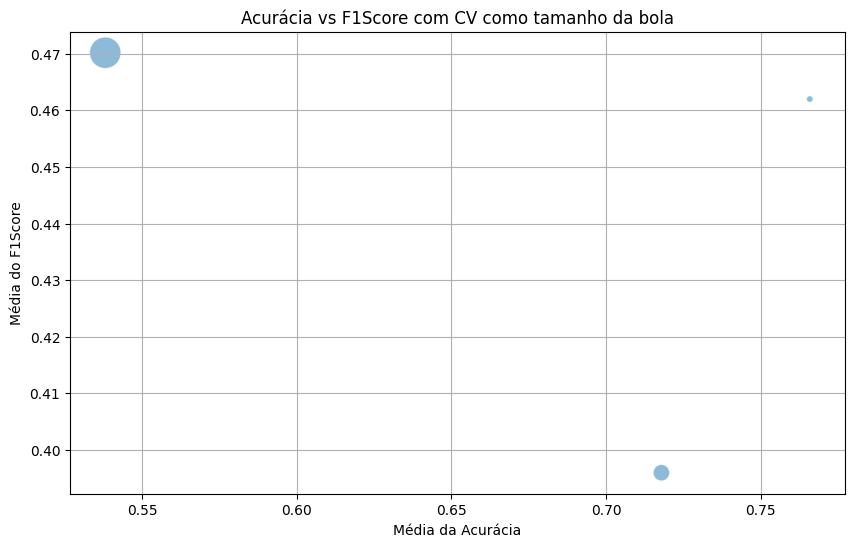

,Experimento,Projeto,method,Acuracia mean,Acuracia std,F1ScoreMacro mean,F1ScoreMacro std,Acuracia cv,F1ScoreMacro cv,CV_Mean,bubble_size
0,Argmax,Artigo,binary,0.538095,0.297605,0.470180,0.183821,55.307235,39.095852,47.201544,4720.154359
1,Argmax,Artigo,termfrequency,0.717875,0.067988,0.395974,0.146583,9.470787,37.018425,23.244606,2324.460582
2,Argmax,Artigo,tfidf,0.765849,0.045539,0.462001,0.117960,5.946168,25.532402,15.739285,1573.928471


In [130]:
filters = {"method":[]}  # Exemplo de filtro
visualizer.plot_acuracy_vs_f1score(filters)
visualizer.stats_df

C:\Users\ghdaru\AppData\Local\Temp\ipykernel_37652\3434680285.py:327: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  scatter = sns.scatterplot(data=stats_df, x='Acuracia mean', y='F1ScoreMacro mean',


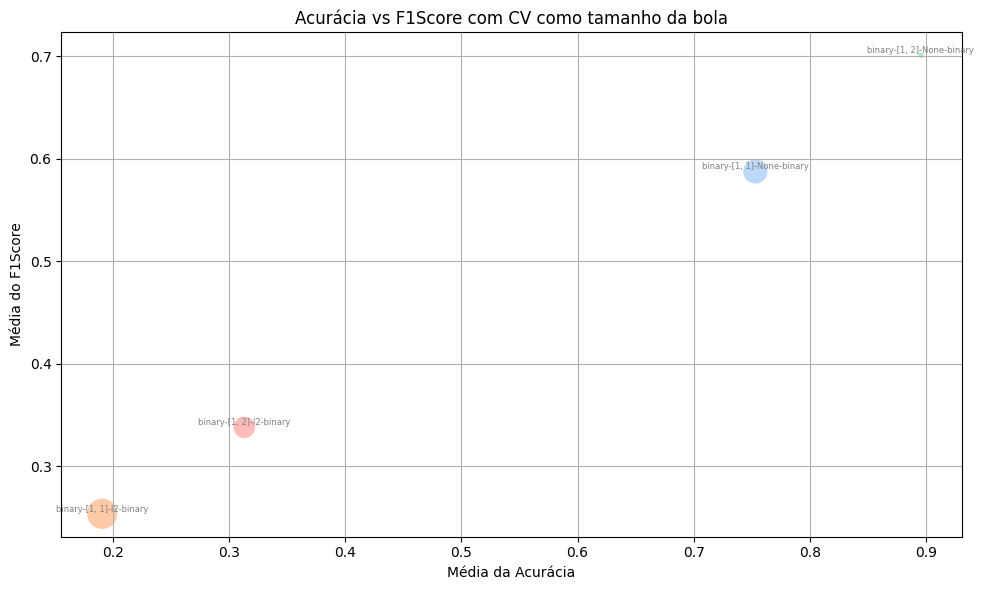

,Experimento,Projeto,Parameters_Label,method,Acuracia mean,Acuracia std,F1ScoreMacro mean,F1ScoreMacro std,Acuracia cv,F1ScoreMacro cv,Labels,bubble_size
0,Argmax,Artigo,"binary-[1, 1]-None",binary,0.753092,0.003339,0.587712,0.018489,0.443435,3.145849,"binary-[1, 1]-None-binary",179.464150
1,Argmax,Artigo,"binary-[1, 1]-l2",binary,0.190686,0.004569,0.253889,0.005175,2.396068,2.038462,"binary-[1, 1]-l2-binary",221.726486
2,Argmax,Artigo,"binary-[1, 2]-None",binary,0.895577,0.001862,0.700921,0.013354,0.207912,1.905186,"binary-[1, 2]-None-binary",105.654923
3,Argmax,Artigo,"binary-[1, 2]-l2",binary,0.313024,0.004631,0.338196,0.005975,1.479487,1.766763,"binary-[1, 2]-l2-binary",162.312468


In [190]:
filters = {"Parameters_Label":[], "method":["binary"]}  # Exemplo de filtro
visualizer.plot_acuracy_vs_f1score2(filters)
visualizer.stats_df